In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from src.metrics import calculate_hypervolume
import importlib
import src.optimizer
importlib.reload(src.optimizer)
from src.optimizer import Optimizer
import src.ISPEA2Optimizer
importlib.reload(src.ISPEA2Optimizer)
from src.ISPEA2Optimizer import ISPEA2Optimizer
from src.network_creator import NetworkCreator
import random
import pandas as pd

In [26]:

def run_experiment(network, start_node, end_node, population_size, generations, reference_point, runs=5):
    hv_nsga2_all = []
    hv_ispea2_all = []

    for i in range(runs):
        seed = 100 + i
        random.seed(seed)
        np.random.seed(seed)

        nsga2_opt = Optimizer(start_node, end_node, network, population_size, 0.2, 0.3, generations)
        ispea2_opt = ISPEA2Optimizer(start_node, end_node, network, population_size, 0.2, 0.3, generations)

        front_nsga2 = nsga2_opt.nsga2()
        front_ispea2 = ispea2_opt.run()

        def transform(front):
            for ind in front:
                ind.metrics = [-ind.metrics[0], ind.metrics[1], ind.metrics[2]]
            return front

        front_nsga2 = transform(front_nsga2)
        front_ispea2 = transform(front_ispea2)

        hv_nsga2 = calculate_hypervolume(front_nsga2, reference_point)
        hv_ispea2 = calculate_hypervolume(front_ispea2, reference_point)

        hv_nsga2_all.append(hv_nsga2)
        hv_ispea2_all.append(hv_ispea2)

    return hv_nsga2_all, hv_ispea2_all


def run_all():
    reference_point = [0, 1000, 1.0]
    generations = 10
    runs = 5

    sizes = [1, 5, 10]
    networks = {
        "full_mesh_20": NetworkCreator().create_full_mesh_network(20),
        "full_mesh_40": NetworkCreator().create_full_mesh_network(40),
        "janos-us-ca": NetworkCreator("network_source/janos-us-ca").create_physical_network()
    }

    start_node = "1"  # for full mesh
    end_node = "2"    # for full mesh
    start_real = "Portland"
    end_real = "Miami"

    results = {}

    for net_name, net in networks.items():
        print(f"\n--- Testing on network: {net_name} ---")
        for size in sizes:
            print(f"\n  >> Running for population size = {size}")
            s_node = start_node if "full" in net_name else start_real
            e_node = end_node if "full" in net_name else end_real
            hv_nsga2, hv_ispea2 = run_experiment(net, s_node, e_node, size, generations, reference_point, runs)
            results[(net_name, size)] = {
                "NSGA2": (np.mean(hv_nsga2), np.std(hv_nsga2)),
                "ISPEA2": (np.mean(hv_ispea2), np.std(hv_ispea2)),
            }

    # Print results
    print("\n=== Summary ===")
    for key, value in results.items():
        net_name, size = key
        print(f"\nNetwork: {net_name}, Pop: {size}")
        print(f"  NSGA-II HV: mean = {value['NSGA2'][0]:.2f}, std = {value['NSGA2'][1]:.2f}")
        print(f"  ISPEA2  HV: mean = {value['ISPEA2'][0]:.2f}, std = {value['ISPEA2'][1]:.2f}")


    results = []

    for net_name, net in networks.items():
        for size in sizes:
            s_node = start_node if "full" in net_name else start_real
            e_node = end_node if "full" in net_name else end_real
            hv_nsga2, hv_ispea2 = run_experiment(net, s_node, e_node, size, generations, reference_point, runs)
            results.append({
                "Network": net_name,
                "PopSize": size,
                "NSGA-II HV Mean": np.mean(hv_nsga2),
                "NSGA-II HV Std": np.std(hv_nsga2),
                "ISPEA2 HV Mean": np.mean(hv_ispea2),
                "ISPEA2 HV Std": np.std(hv_ispea2),
            })
    
    df_results = pd.DataFrame(results)
    print(df_results)
    return df_results


In [30]:
def plot_results_bar(df_results):
    networks = df_results["Network"].unique()
    pop_sizes = df_results["PopSize"].unique()
    
    fig, ax = plt.subplots(figsize=(12, 6))

    width = 0.35  # szerokość słupka
    x = np.arange(len(networks)*len(pop_sizes))

    nsga2_means = []
    ispea2_means = []
    labels = []

    for net in networks:
        for pop in pop_sizes:
            row = df_results[(df_results["Network"]==net) & (df_results["PopSize"]==pop)]
            nsga2_means.append(float(row["NSGA-II HV Mean"].iloc[0]))
            ispea2_means.append(float(row["ISPEA2 HV Mean"].iloc[0]))
            labels.append(f"{net}\nPop={pop}")

    ax.bar(x - width/2, nsga2_means, width, label='NSGA-II')
    ax.bar(x + width/2, ispea2_means, width, label='ISPEA2')

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel("Mean Hypervolume (HV)")
    ax.set_title("Porównanie średnich HV dla NSGA-II i ISPEA2")
    ax.legend()
    ax.grid(axis='y')

    plt.tight_layout()
    plt.show()


In [31]:
df=run_all()



--- Testing on network: full_mesh_20 ---

  >> Running for population size = 1

  >> Running for population size = 5

  >> Running for population size = 10

--- Testing on network: full_mesh_40 ---

  >> Running for population size = 1

  >> Running for population size = 5

  >> Running for population size = 10

--- Testing on network: janos-us-ca ---

  >> Running for population size = 1

  >> Running for population size = 5

  >> Running for population size = 10

=== Summary ===

Network: full_mesh_20, Pop: 1
  NSGA-II HV: mean = 898311.71, std = 89342.48
  ISPEA2  HV: mean = 232736.30, std = 292767.00

Network: full_mesh_20, Pop: 5
  NSGA-II HV: mean = 815659.35, std = 254647.19
  ISPEA2  HV: mean = 418294.04, std = 428979.37

Network: full_mesh_20, Pop: 10
  NSGA-II HV: mean = 0.00, std = 0.00
  ISPEA2  HV: mean = 67862.72, std = 135725.44

Network: full_mesh_40, Pop: 1
  NSGA-II HV: mean = 179884.24, std = 53023.44
  ISPEA2  HV: mean = 52278.41, std = 33888.02

Network: full_mesh

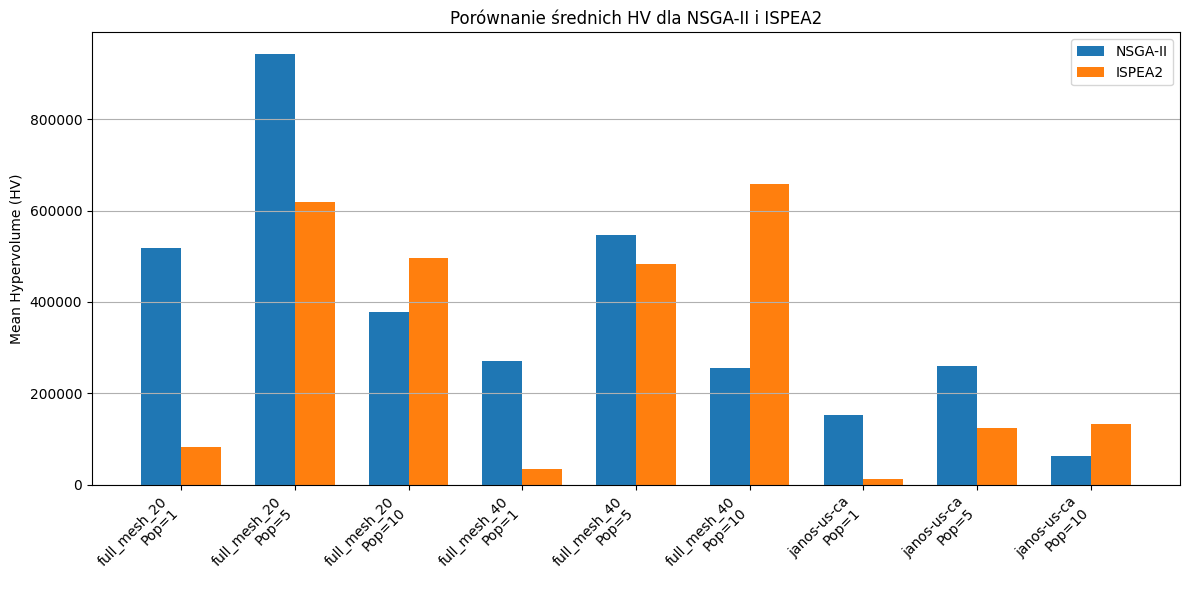

In [33]:
plot_results_bar(df)